In [49]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import serial
from serial.tools import list_ports
from datetime import datetime
from scipy.fft import fft, fftfreq

In [3]:
ports = list_ports.comports()
devices = [info.device for info in ports]
devices

['COM3', 'COM6']

In [20]:
datetime.now().strftime("%Y%m%d_%H%M%S")

'20230529_151819'

Serial<id=0x1df9be9e560, open=True>(port='COM3', baudrate=115200, bytesize=8, parity='N', stopbits=1, timeout=1, xonxoff=False, rtscts=False, dsrdtr=False)
 -0.04858 1.01147 0.07349 False
364618 -0.04858 1.01147 0.07349 False
364898 -0.04858 1.01147 0.07349 False
365180 -0.04858 1.01147 0.07349 False
365462 -0.04858 1.01147 0.07349 False
365752 -0.04858 1.01147 0.07349 False
366034 -0.04858 1.01147 0.07349 False
366316 -0.04858 1.01147 0.07349 False
366598 -0.04858 1.01147 0.07349 False
366882 -0.04858 1.01147 0.07349 False
367164 -0.04858 1.01147 0.07349 False
367447 -0.04858 1.01147 0.07349 False
367732 -0.04858 1.01147 0.07349 False
368015 -0.04858 1.01147 0.07349 False
368297 -0.04858 1.01147 0.07349 False
368579 -0.04858 1.01147 0.07349 False
368862 -0.06079 1.01172 0.09180 False
369144 -0.06079 1.01172 0.09180 False
369426 -0.06079 1.01172 0.09180 False
369712 -0.06079 1.01172 0.09180 False
369994 -0.06079 1.01172 0.09180 False
370277 -0.06079 1.01172 0.09180 False
370559 -0.0607

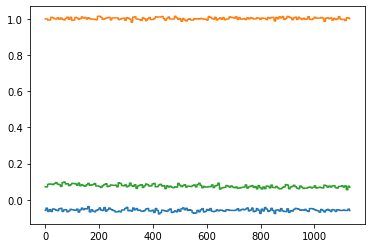

In [30]:
break_flag = False
is_data_available = False
t_list = []
accX_list = []
accY_list = []
accZ_list = []

save_data = True
is_started = False
DIR = "data"

if not os.path.exists(DIR):
    os.makedirs("data")


with serial.Serial("COM3", 115200, timeout=1) as ser:
    print(ser)
    while True:
        try:
            line = ser.readline()   # read a '\n' terminated line
            text_data = line.decode().split("\n")[0]
            print(text_data, is_started)
            
            
            if "start" in text_data:
                print("receiving data now")
                is_started = True
                t_list = []
                accX_list = []
                accY_list = []
                accZ_list = []
                now_str = datetime.now().strftime("%Y%m%d_%H%M%S")
                
                
            elif is_started and ("end" in text_data):
                is_started = False
                plt.plot(t_list, accX_list, label="Z")
                plt.plot(t_list, accY_list, label="Y")
                plt.plot(t_list, accZ_list, label="Z")
                df = pd.DataFrame()
                df["time(ms)"]=t_list
                df["accX(G)"]=accX_list
                df["accY(G)"]=accY_list
                df["accZ(G)"]=accZ_list
                df.to_csv(os.path.join(DIR, f"{now_str}.csv"), index=False)
                break_flag = True
            
            elif is_started and (text_data != ""):
                t, accX, accY, accZ = text_data.split(" ")
                t_list.append(int(t)/1000)
                accX_list.append(float(accX))
                accY_list.append(float(accY))
                accZ_list.append(float(accZ))
                
            
        except ValueError:
            pass

        except KeyboardInterrupt:
            # print(t_list)
            print("Keyboard Interrupt")
            ser.close()
            break_flag = True
        
        if break_flag: break

In [31]:
df = pd.read_csv("imu_data/20230529_165023_test.csv")
df

,time(ms),accX(G),accY(G),accZ(G)
0,435,-0.76709,-0.42578,0.51733
1,725,-0.76709,-0.42578,0.51733
2,1007,-0.76709,-0.42578,0.51733
3,1290,-0.76709,-0.42578,0.51733
4,1572,-0.76709,-0.42578,0.51733
...,...,...,...,...
3995,1130058,-1.57690,-0.50391,0.61499
3996,1130340,-1.57690,-0.50391,0.61499
3997,1130631,-1.57690,-0.50391,0.61499
3998,1130914,-1.57690,-0.50391,0.61499


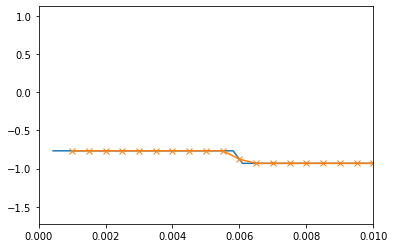

In [66]:
t = df["time(ms)"]/1E6
accX = df["accX(G)"]

dt = 0.5E-3

t_vals = np.arange(2*dt, 1+2*dt, dt)

accX_interp = np.interp(t_vals, t, accX)

plt.plot(t, accX)
plt.plot(t_vals, accX_interp, marker="x")
plt.xlim(0, 0.01)

F = np.fft.fft(accX_interp) # 変換結果
freq = np.fft.fftfreq(t_vals.shape[0], d=dt) # 周波数


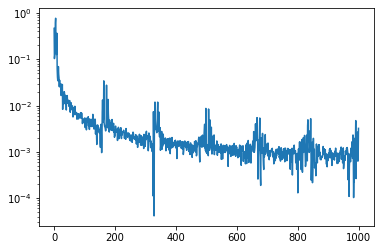

In [67]:

n = t_vals.shape[0]

freq = fftfreq(n, dt)[:n//2]
amp = np.abs(fft(accX_interp)[:n//2])/(n/ 2)



plt.plot(freq, amp)
plt.yscale("log")

In [68]:
n

2000